<a href="https://colab.research.google.com/github/MegaDewi2/Classification-Fake-News-Covid-19/blob/main/Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

import nltk
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout, Bidirectional
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer


nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
drive.mount('/content/drive/')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Mounted at /content/drive/


In [ ]:
os.chdir('/content/drive/My Drive/Metpen')
!ls -a

fake_new_dataset.xlsx  glove.840B.300d.txt


In [ ]:
fake_news = pd.read_excel('fake_new_dataset.xlsx')
fake_news

,Unnamed: 0,title,text,subcategory,label
0,0,FACEBOOK DELETES MICHIGAN ANTI-LOCKDOWN GROUP ...,Facebook has shuttered a popular group for Mic...,false news,0
1,1,Other Viewpoints: COVID-19 is worse than the flu,We can now officially put to rest all comparis...,true,1
2,2,Bermuda's COVID-19 cases surpass 100,The Ministry of Health in Bermuda has confirme...,true,1
3,3,Purdue University says students face 'close to...,"Purdue University President Mitch Daniels, the...",partially false,0
4,4,THE HIGH COST OF LOCKING DOWN AMERICA: “WE’VE ...,Locking down much of the country may have help...,false news,0
...,...,...,...,...,...
3114,2998,2019-nCoV: Health dept. on full alert,Quarantine advised for 80 persons across the S...,true,1
3115,2999,Screening machine for corona virus launched at...,South Sudan has begun screening all travelers ...,true,1
3116,3000,Coronavirus (2019-nCoV),Coronavirus (2019-nCoV) is a new respiratory i...,true,1
3117,3001,Characterizing Patients Hospitalized With COVI...,Characterizing Patients Hospitalized With COVI...,false news,0


In [ ]:
fake_news.shape

(3119, 5)

In [ ]:
fake_news = fake_news.drop_duplicates(subset="text",ignore_index=True)

In [ ]:
fake_news.isnull().sum()

Unnamed: 0     0
title          1
text           0
subcategory    0
label          0
dtype: int64

In [ ]:
fake_news.dropna(inplace=True)
fake_news.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Unnamed: 0     0
title          0
text           0
subcategory    0
label          0
dtype: int64

In [ ]:
fake_news = fake_news.drop(['Unnamed: 0','subcategory'], axis=1)

In [ ]:
fake_news['text'] = fake_news['text'] + " " + fake_news['title']

In [ ]:
fake_news['label'].describe()

count    3059.000000
mean        0.658712
std         0.474219
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

In [ ]:
fake_news['label'].value_counts()

1    2015
0    1044
Name: label, dtype: int64

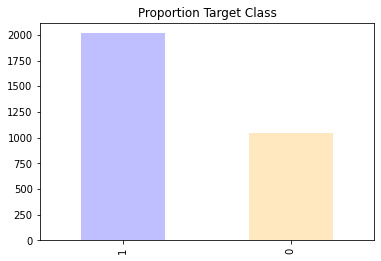

In [ ]:
count_class=pd.value_counts(fake_news['label'], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"], alpha = 0.25)
plt.title('Proportion Target Class')
plt.show()

In [ ]:
from collections import Counter
fake_news['temp_list']=fake_news['text'].apply(lambda x: str(x).split())
top=Counter([word for li in fake_news['temp_list'] for word in li])
temp_1=pd.DataFrame(top.most_common(20))
temp_1.columns=["most_common_words","frequency"]
temp_1.style.background_gradient(cmap='Blues')

,most_common_words,frequency
0,the,82845
1,of,44902
2,to,44246
3,and,40715
4,in,32377
5,a,25557
6,is,18177
7,that,15973
8,for,13813
9,with,11783


In [ ]:
#true
from collections import Counter
count1 = Counter(" ".join(fake_news[fake_news['label']== 1]['text']).\
                 split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)

#false
count2 = Counter(" ".join(fake_news[fake_news['label']== 1]['text']).\
                 split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)

In [ ]:
df1 = df1.rename(columns={0: "common_words", 1 : "count"})
df2 = df2.rename(columns={0: "common_words", 1 : "count"})

Text(0.5, 1.0, 'Fake')

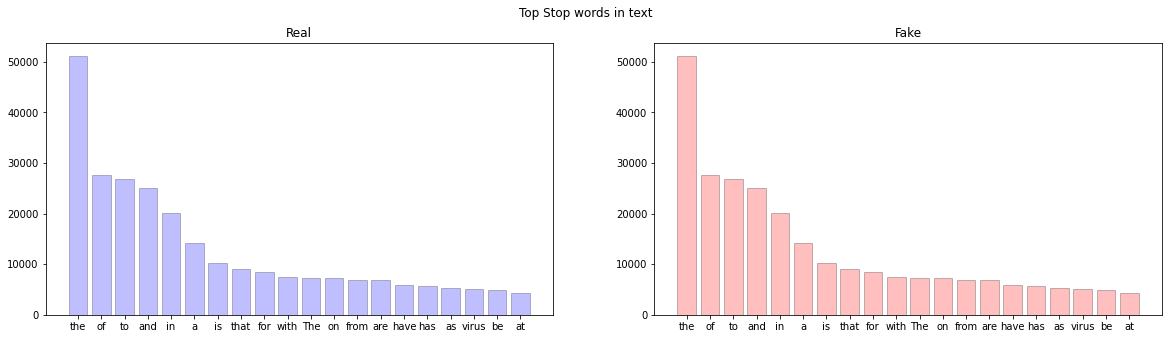

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
fig.suptitle('Top Stop words in text')
ax1.bar(df1['common_words'], df1['count'], color='blue', alpha=0.25, edgecolor='black')
ax1.set_title("Real")

ax2.bar(df2['common_words'], df2['count'], color='red', alpha=0.25, edgecolor='black')
ax2.set_title("Fake")

In [ ]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
def clean(text):    
  
  def contractions_check(text_cnt):
    global contractions
    res = ""
    for word in text_cnt.split():
      if word in contractions:
        res += contractions[word] + ' '
      else:
        res += word + ' '
    return res.strip()

  text = str(text).lower().strip()
  printable = set(string.printable)
  text = "".join(list(filter(lambda x: x in printable, text)))
  text = contractions_check(text)
  return text

In [ ]:
def preprocess_text(data):
    stop = stopwords.words('english')
    punct = '''!"#$%&'()*+,-/:;<=>?@[\]^_`{|}~'''
    #Make lower
    data['text'] = data['text'].str.lower()
    #Remove stopwords
    data['text'] = data['text'].apply(lambda x:' '.join([words for words in x.split() if words not in stop]))
    #Remove punctuations
    data['text'] = data['text'].str.translate(str.maketrans('', '', punct))
    data['word_count'] = data['text'].str.split().str.len()
    return data
fake_news = preprocess_text(fake_news)

In [ ]:
def pos_tag(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag,wordnet.NOUN)

In [ ]:
def lemmatize(data):
    lemmatizer=WordNetLemmatizer()
    data['text'] = data['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w,pos_tag(w)) for w in word_tokenize(x)]))
    return data

fake_news = lemmatize(fake_news)

In [ ]:
fake_news['text'][:2]

0    facebook shutter popular group michigander opp...
1    officially put rest comparison covid19 influen...
Name: text, dtype: object

In [ ]:
true = fake_news['text'][fake_news['label']==1]
false = fake_news['text'][fake_news['label']==0]
stop = set(stopwords.words('english'))
print(stop)

{'wouldn', 'me', 'an', 'and', 'who', "didn't", 'it', 'most', 'didn', 'y', 'further', 'the', 'by', "you've", "aren't", 'themselves', "you'd", 'but', 'wasn', 'won', 'from', "couldn't", 'same', 'your', 'ain', 'm', 'when', 'only', "needn't", 'had', 'until', 'myself', 'nor', 'should', 'himself', 'during', "shouldn't", 'have', 'he', 'here', 'through', 'yours', 'don', 'own', 've', 'our', "you're", 'down', 'shouldn', 'theirs', 'no', 'needn', 'itself', 'few', 'be', 'mustn', 'herself', 'my', 'they', 'having', 'd', 'mightn', 'over', 'again', "haven't", 'its', 'off', 'i', "shan't", 'been', 'to', 'or', 're', 'hadn', 'where', 'can', 'o', 'what', 'weren', 'into', 'once', "doesn't", 'other', "wouldn't", 'which', "isn't", 'yourself', 'did', "mightn't", 'then', 'ma', 'do', 'being', 't', 'those', 'shan', 'any', 'will', 'this', 'because', 'in', 'his', 'their', "mustn't", 'each', 'am', 'has', 'at', 'we', "that'll", 'above', 'more', 'too', 'than', "wasn't", 'up', 'there', 'now', 'so', 'about', 'you', 'for',

<function matplotlib.pyplot.show>

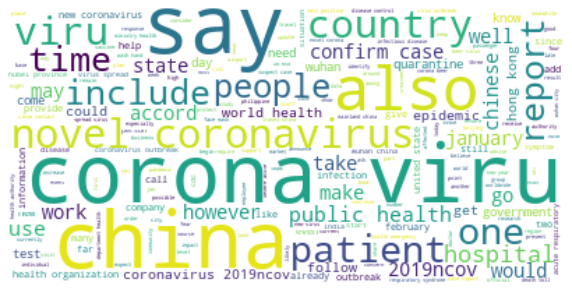

In [ ]:
plt.figure(figsize=(10,8))
true_wc = WordCloud(stopwords=stop, background_color='white').generate(' '.join(true))
plt.imshow(true_wc, interpolation='bilinear')
plt.axis("off")
plt.show

<function matplotlib.pyplot.show>

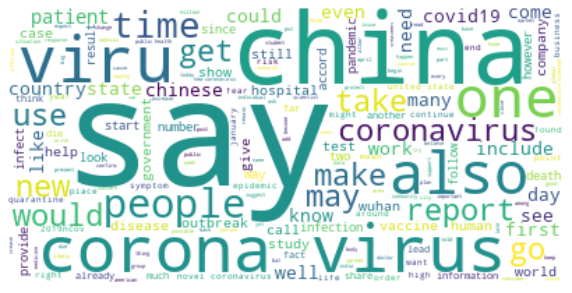

In [ ]:
plt.figure(figsize=(10,8))
false_wc = WordCloud(stopwords=stop, background_color='white').generate(' '.join(false))
plt.imshow(false_wc, interpolation='bilinear')
plt.axis("off")
plt.show

In [ ]:
fake_news.shape

(3059, 5)

## RNN

In [ ]:
x = fake_news['text']
Y = fake_news['label']

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(x, Y, test_size=0.20, random_state=0)

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train1)

In [ ]:
X_train1 = tokenizer.texts_to_sequences(X_train1)
X_test1 = tokenizer.texts_to_sequences(X_test1)

In [ ]:
X_train1 = tf.keras.preprocessing.sequence.pad_sequences(X_train1, padding='post', maxlen=256)
X_test1 = tf.keras.preprocessing.sequence.pad_sequences(X_test1, padding='post', maxlen=256)

In [ ]:
EMBEDDING_FILE = 'glove.840B.300d.txt'

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_vocab, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_vocab: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
from keras.callbacks import ReduceLROnPlateau

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
maxlen = 300

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_vocab, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25)))
model.add(Bidirectional(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid')) 
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1.0000e-04), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 256)          439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,607,809
Trainable params: 607,809
Non-trainable params: 3,000,000
_________________________________________________________________


In [ ]:
batch_size = 300
epochs = 10
embed_size = 300

In [ ]:
history = model.fit(X_train1, y_train1, batch_size = batch_size , validation_data = (X_test1,y_test1) , epochs = 10 , callbacks = [learning_rate_reduction])

Epoch 1/10
9/9 [==============================] - 157s 14s/step - loss: 0.6789 - accuracy: 0.5554 - val_loss: 0.6424 - val_accuracy: 0.6503
Epoch 2/10
9/9 [==============================] - 117s 13s/step - loss: 0.6344 - accuracy: 0.6608 - val_loss: 0.6356 - val_accuracy: 0.6503
Epoch 3/10
9/9 [==============================] - 115s 13s/step - loss: 0.6250 - accuracy: 0.6629 - val_loss: 0.6304 - val_accuracy: 0.6487

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 4/10
9/9 [==============================] - 114s 13s/step - loss: 0.6195 - accuracy: 0.6616 - val_loss: 0.6252 - val_accuracy: 0.6487
Epoch 5/10
9/9 [==============================] - 114s 13s/step - loss: 0.6149 - accuracy: 0.6620 - val_loss: 0.6207 - val_accuracy: 0.6503

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 6/10
9/9 [==============================] - 118s 13s/step - loss: 0.6133 - accuracy: 0.6633 - val_loss: 0.6188 - val_accuracy: 0.650

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train1,y_train1)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test1,y_test1)[1]*100 , "%")

77/77 [==============================] - 28s 367ms/step - loss: 0.6039 - accuracy: 0.6653
Accuracy of the model on Training Data is -  66.53044819831848 %
20/20 [==============================] - 7s 358ms/step - loss: 0.6136 - accuracy: 0.6487
Accuracy of the model on Testing Data is -  64.8692786693573 %


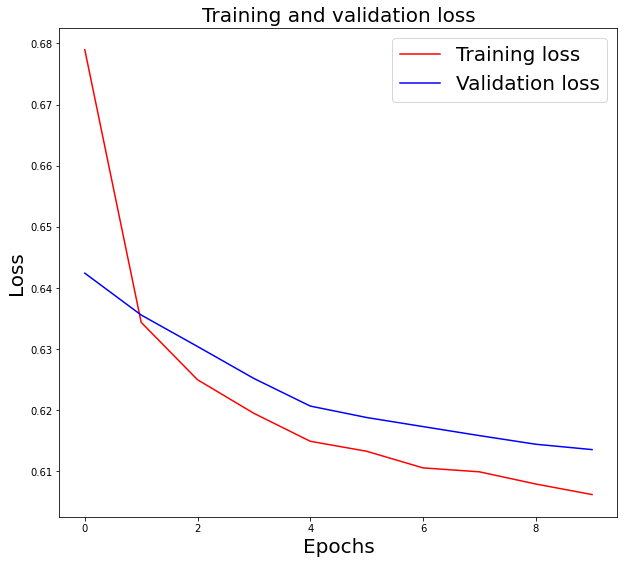

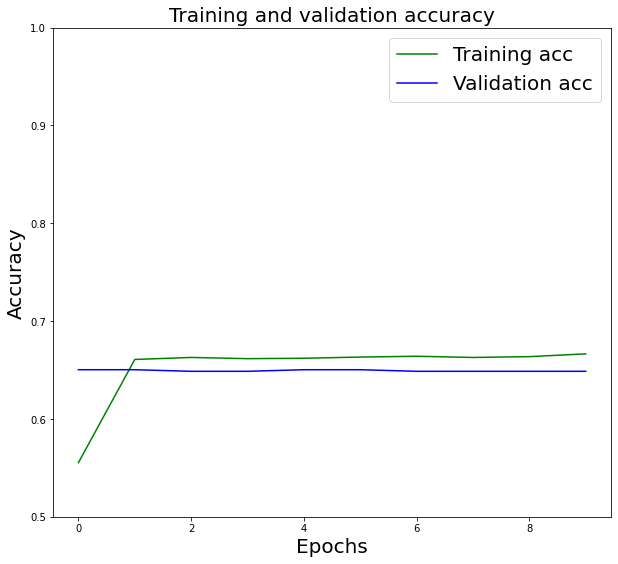

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(10,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(10,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [ ]:
model.evaluate(X_test1, y_test1)

20/20 [==============================] - 7s 362ms/step - loss: 0.6136 - accuracy: 0.6487


[0.6135602593421936, 0.648692786693573]

In [ ]:
pred = model.predict(X_test1)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [ ]:
print(confusion_matrix(binary_predictions,y_test1))

print(classification_report(binary_predictions,y_test1))


[[  1   1]
 [214 396]]
              precision    recall  f1-score   support

           0       0.00      0.50      0.01         2
           1       1.00      0.65      0.79       610

    accuracy                           0.65       612
   macro avg       0.50      0.57      0.40       612
weighted avg       0.99      0.65      0.78       612

